In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import stumpy
import numpy as np

from sklearn.decomposition import PCA
import sklearn.cluster as cluster

from matplotlib.pyplot import figure

## Feature Engineering

### In this code block we will add features to prepare for the upcoming data analysis

In [6]:
original = pd.read_table("data/tracklets_0114.txt", sep='\t')

df = original #Feature engineering for PCA
dk = original #Feature engineering for K means clustering
dl = original #Feature engineering for time-series analysis

# Here we will find the distance and duration features
df['distance'] = abs(df['end_sensor'] - df['begin_sensor'])
df['duration'] = ((df['end_time'] - df['begin_time']) / 1000).astype(int)

# Here we convert the time into data time format
dl['begin_time'] = pd.to_datetime(dl['begin_time'], unit='ms')
dl['end_time'] = pd.to_datetime(dl['end_time'], unit='ms')

# Here we will find the specific hour that the activation occcured
dk['hour'] = dl['begin_time'].dt.hour
dk = dk.head(1000) #we will only collect the first 1000 data points

## PCA

### In the following code blocks we will perform Principal Component Analysis in order to determine the most significant components of the data

In [7]:
#picture of the office will be inserted here

In [8]:
'''
This function will take the sensor id as input, check under what range 
it will be, and return a corresponding output
'''

def targetting(sensors):
    if(256 < sensors < 290):
        return 1
    elif (454 < sensors < 502):
        return 2
    elif(395 < sensors < 444):
        return 3
    else: 
        return 0

In [9]:
'''
In his code block we will call the targetting function and save the values
into the column 'area'. Then we will drop all rows that have the value 0 in
the area column
'''

df['area'] = df['begin_sensor'].apply(targetting)

data_with_index = df.set_index('area')
data_with_index = data_with_index.drop(0)
data_with_index = data_with_index.reset_index()

In [10]:
'''
Now we will create two new dataframe called x and y, which will be 
the co ordinates for our pca graph.
'''

y = data_with_index['begin_sensor'].apply(targetting) 

#this drops the un needed columns for axis x
data_with_index.drop('begin_time', inplace=True, axis=1)
data_with_index.drop('end_time', inplace=True, axis=1)
data_with_index.drop('area', inplace=True, axis=1)

x = data_with_index
pca = PCA(n_components=2)
x_transform = pca.fit_transform(x)
x_transform

array([[112.65044516,   2.85556608],
       [130.28525617,   2.38385568],
       [121.78884859,   2.01489528],
       ...,
       [ 95.48118102,  -6.80108194],
       [120.54202584,  34.86847049],
       [121.48051051,  14.69574496]])

In [11]:
'''
In this cell we initiate the colors and labels for our plot
'''

colors = ['#ffffff', '#bc5090', '#ffa600', '#219a26']
lw=2

labelled = np.full((4), np.string_)

labelled[0] = 'unknown'
labelled[1] = '8th floor - East (0)'
labelled[2] = '7th floor - North'
labelled[3] = '7th floor - South (2)'

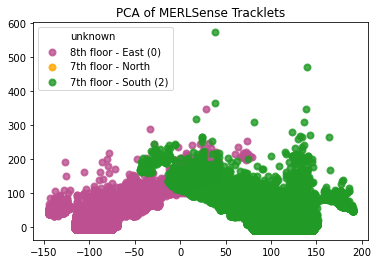

In [12]:
'''
In this cell we will plot the PCA to our results
'''

plt.figure()

for color, i, target_name in zip(colors, [0, 1, 2, 3], labelled):
    plt.scatter(x_transform[y == i, 0], x_transform[y == i, 1], color=color, alpha=.8, lw=lw,
                label=labelled[i])
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of MERLSense Tracklets');

# K-means clustering

In [10]:
dk

,begin_sensor,end_sensor,begin_time,end_time,distance,duration,hour
1,420,416,2006-03-22 04:00:24.919,2006-03-22 04:00:39.867,4,14,4
2,434,427,2006-03-22 04:04:17.723,2006-03-22 04:04:25.970,7,8,4
3,428,421,2006-03-22 04:06:50.882,2006-03-22 04:06:58.410,7,7,4
4,420,428,2006-03-22 04:08:39.498,2006-03-22 04:09:15.841,8,36,4
5,423,421,2006-03-22 04:09:17.575,2006-03-22 04:09:21.250,2,3,4
...,...,...,...,...,...,...,...
996,322,322,2006-03-22 14:04:25.354,2006-03-22 14:04:26.374,0,1,14
997,327,327,2006-03-22 14:04:25.510,2006-03-22 14:04:45.017,0,19,14
998,256,256,2006-03-22 14:04:26.797,2006-03-22 14:04:27.819,0,1,14
999,323,323,2006-03-22 14:04:27.280,2006-03-22 14:04:28.301,0,1,14


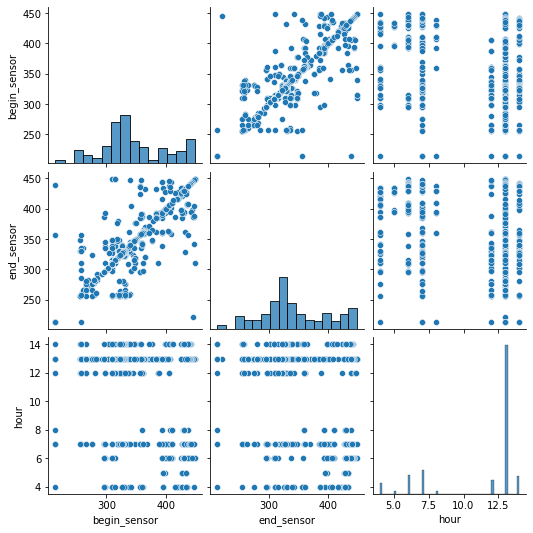

In [11]:
sns.pairplot(dk[['begin_sensor', 'end_sensor', 'hour']])

/var/folders/5z/rs5_z6w113b3qtl8nw6qrdh00000gn/T/ipykernel_6329/953812117.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dk['Clusters'] = kmeans.labels_


<AxesSubplot:xlabel='hour', ylabel='begin_sensor'>

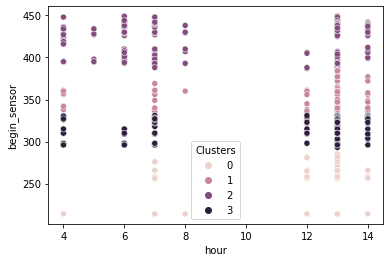

In [12]:

kmeans = cluster.KMeans( n_clusters = 4, init="k-means++")
kmeans = kmeans.fit(dk[['hour','begin_sensor']])

dk['Clusters'] = kmeans.labels_

sns.scatterplot(x="hour", y="begin_sensor", hue="Clusters", data=dk)

# Kalman filter/time-series analysis

In [13]:
dl

,begin_sensor,end_sensor,begin_time,end_time,distance,duration,hour,placeholder
1,420,416,2006-03-22 04:00:24.919,2006-03-22 04:00:39.867,4,14,4,3
2,434,427,2006-03-22 04:04:17.723,2006-03-22 04:04:25.970,7,8,4,3
3,428,421,2006-03-22 04:06:50.882,2006-03-22 04:06:58.410,7,7,4,3
4,420,428,2006-03-22 04:08:39.498,2006-03-22 04:09:15.841,8,36,4,3
5,423,421,2006-03-22 04:09:17.575,2006-03-22 04:09:21.250,2,3,4,3
...,...,...,...,...,...,...,...,...
1169168,406,406,2006-06-11 04:03:35.008,2006-06-11 04:03:36.014,0,1,4,3
1169169,358,358,2006-06-11 04:03:35.201,2006-06-11 04:03:36.225,0,1,4,0
1169170,358,290,2006-06-11 04:03:39.007,2006-06-11 04:03:46.878,68,7,4,0
1169171,422,424,2006-06-11 04:23:48.660,2006-06-11 04:25:12.910,2,84,4,3


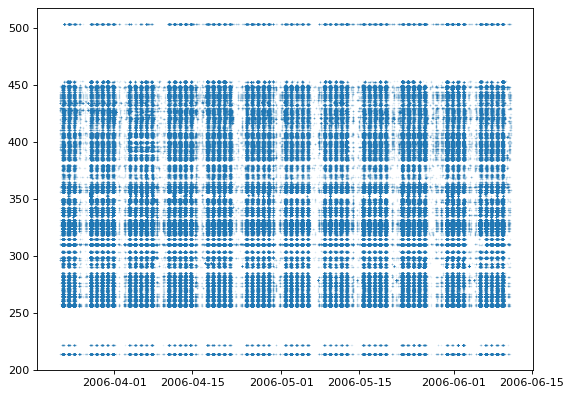

In [14]:
figure(figsize=(8, 6), dpi=80)
plt.scatter(df['begin_time'], dl['begin_sensor'], s=0.005)

plt.show()

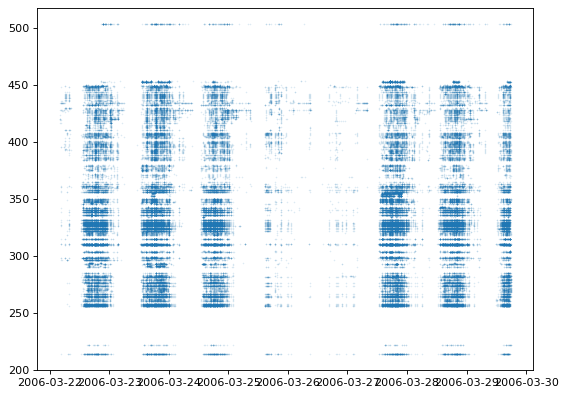

In [15]:
dl = dl.head(100000)
figure(figsize=(8, 6), dpi=80)
plt.scatter(dl['begin_time'], dl['begin_sensor'], s=0.005)

plt.show()